In [167]:
import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import linregress
import matplotlib.pyplot as plt
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
from scipy.signal import argrelextrema


# Many two level systems

## Recap

Last time we saw that when we add just one extra TLS we got surprising new physics - non radiative excitation transfer. What happens when we continue adding TLS? That's what this tutorial is going to be about.

Last time, we motivated that for many TLS, a helpful way to write the Hamiltonian as

$$H =  \Delta E J_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_x$$

In [5]:
H_latex = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_x = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_y = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_z = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$



## Computational bottleneck

We can generalise our "make_operators" function from last time to create operators for an arbitrary number of TLS

In [8]:
def make_operators(max_bosons, parity=0, num_TLS=1):
    
    a     = tensor([destroy(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)])      # tensorised boson destruction operator
    J     = jspin(num_TLS, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])                # tensorised J^2 operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n, *ms) for n in possible_ns for ms in product(possible_ms, repeat=num_TLS)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        J2              = J2.extract_states(p)  
        nm_list        = [nm_list[i] for i in p]
  
    
    return two_state, bosons, interaction, number, nm_list, J2

Right now, the use of J's is allowing us to look at the values of `pseudo-angular momentum` in our system (through the operator J2). We are not however taking advantage of the conservation ideas we spoke about last time and we need to do this to avoid running out of computational resources.

It might seem premature to worry about computational resources, but take a look at what happens when we want to create operators to run simulations on just 32 TLS with only max_bosons=2


In [37]:
two_state, bosons, interaction, number, nmm_list, J2 = make_operators(max_bosons=2, parity=0, num_TLS=32)


OverflowError: value too large

We run out of memory and this is because the number of states needed to describe our system grows exponentially with the number of TLS - every TLS doubles the number of states.

So, how does conservation of `pseudo-angular momentum` help us? Let's explore.

## Pseudo-angular momentum J

## TODO: intro chat

Let's take a look at the case of 2 TLS that we explored last time

In [58]:
Jx, Jy, Jz = jspin(2, basis="uncoupled")
J2 = Jx*Jx + Jy*Jy + Jz*Jz
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

What does this operator tell us?

Just as we learnt about states of constant energy by calculating the eigenvalues and eigenvectors of the Hamiltonian, we can learn about states of constant angular momentum by calculating the eigenvalues and eigenvectors of $J^2$.

In [59]:
evalsJ, eketsJ = J2.eigenstates()

In [60]:
evalsJ

array([0., 2., 2., 2.])

Although not immediately obvious, the eigenvalues of $J^2$ [always have the form $j(j+1)$](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7), where $j$ is a number that characterises the angular momentum of the system with $2j$ being an integer. Therefore, even without explicitly looking at the eigenstates of $J^2$, we know they must correspond to:
- $j=0$ - 1 states
- $j=1$ - 3 states

But, where do these $j$ numbers come from, and what does it mean to have many states with the same value of $j$?


In quantum mechanics, it has been found experimentally that [angular momentum is quantised](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7) in the sense that when its z component is measured it can only take values $m\hbar$ where $m = j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$.

So although we still haven't explicitly looked the 4 eigenstates of $J^2$, we can say that they can be uniquely described by 2 numbers $|j, m \rangle$, namely:

- $|0, 0 \rangle$
- $|1, -1 \rangle$
- $|1, 0 \rangle$
- $|1, 1 \rangle$

The specific $j$ and $m$ numbers come from adding up the angular momentum for many single TLS (with $j=1/2$) like vectors of the same length but different (quantised) orientations. The details are somewhat tedious - often involving [formidable lookup tables](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-clebsch-gordan-coefs.pdf). Luckily for us, QuTiP, has some convenient functions (that are somewhat hidden inside of [`qutip.cy.piqs`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx)) to help us.
- [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) - tells us the different $j$ values for $N$ TSS.
- [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) tells us the $m$ values for a given $j$


Just like parity, we can explore the conservation of pseudo-angular momentum by looking at the commutator of $J^2$ with the $H$.

In [73]:
two_state, bosons, interaction, number, nmm_list, J2 = make_operators(max_bosons=2, parity=0, num_TLS=2)

In [74]:
U=0.01
omega=1
deltaE=1

In [75]:
H = deltaE*two_state + omega*bosons + U*interaction

In [76]:
np.all(commutator(H,J2).full() == 0)

True

We can see that the commutator is indeed zero which tells us that pseudo-angular momentum is conserved. This means if we set up our system with a specific $j$ then we don't have to worry about all the others. 

How can we remove all the others from consideration in out simulations? Luckily for us QuTiP has a function [`jmat`](https://qutip.org/docs/4.4/apidoc/functions.html#qutip.operators.jmat) that allows us to create only the angular momentum operators for a specific $j$. 

In [80]:
Jx, Jy, Jz = jmat(1)
Jz

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]

Above, we can see only states corresponding to $j=1$, i.e. $m=-1,0,+1$

With this in mind we can re-write our operator functions to reduce the computational load

TODO:
- Check parity in below
- say something about change in possible_ms

In [140]:
def make_operators(max_bosons, parity=0, num_TLS=1):
    
    J     = jmat(0.5) if num_TLS==1 else jmat(num_TLS//2)
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    a     = tensor(destroy(max_bosons+1), qeye(J[0].dims[0][0]))                        # tensorised boson destruction operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = range(N, -1,-1)
    nm_list = [(n,m1) for (n,m1) in product(possible_ns, possible_ms)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        nm_list        = [nm_list[i] for i in p]
  
    return two_state, bosons, interaction, number, nm_list

## Superradiance

### 1 TLS excited

time to transfer one = 103.97599399849963


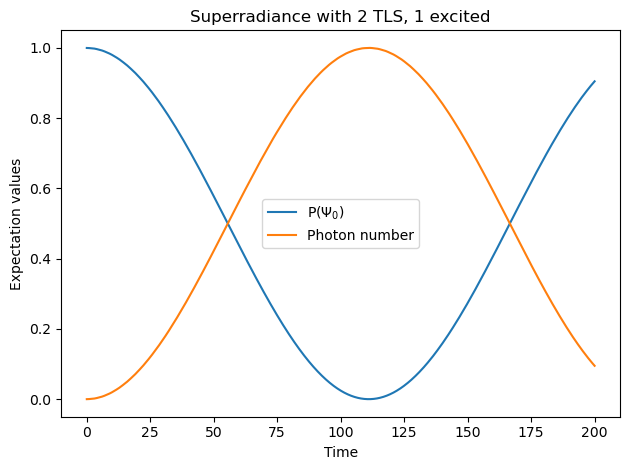

time to transfer one = 73.51837959489873


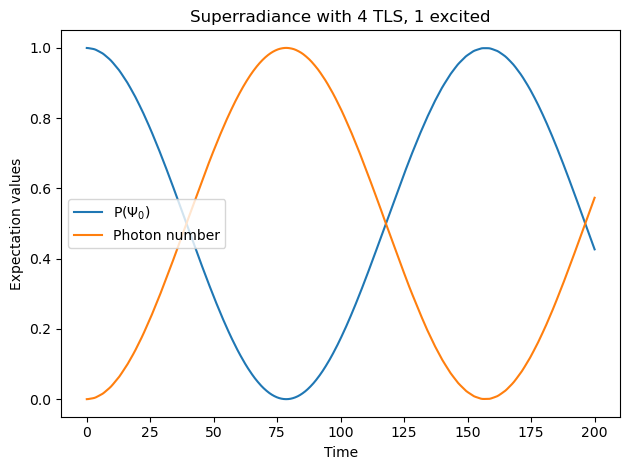

time to transfer one = 51.96299074768692


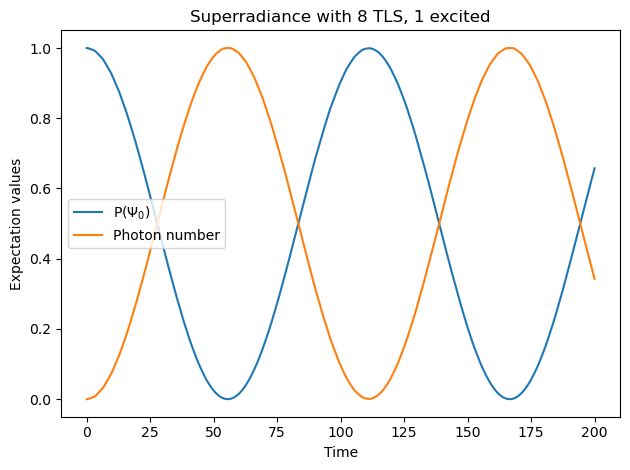

time to transfer one = 36.70917729432358


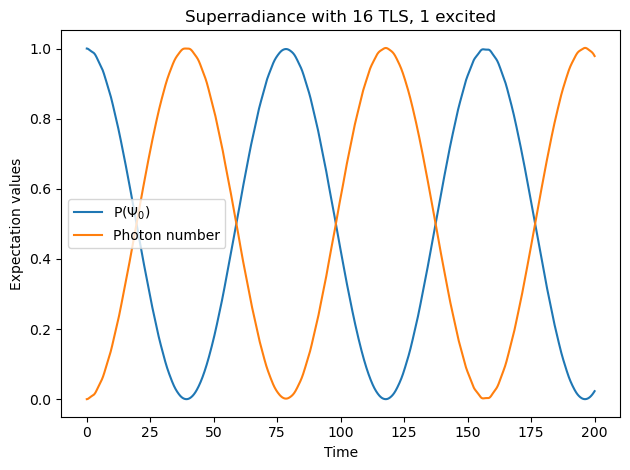

time to transfer one = 25.806451612903228


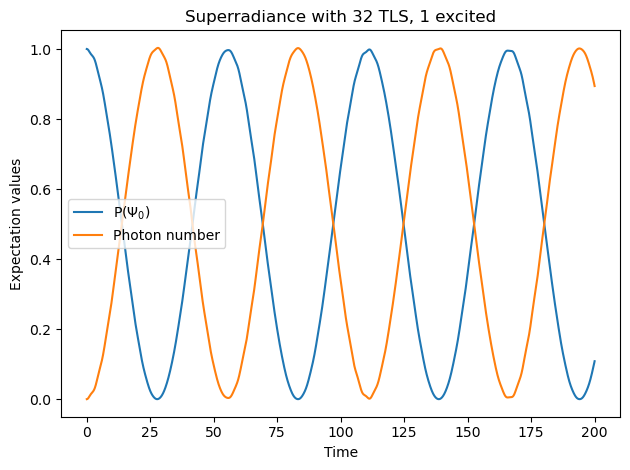

time to transfer one = 23.205801450362593


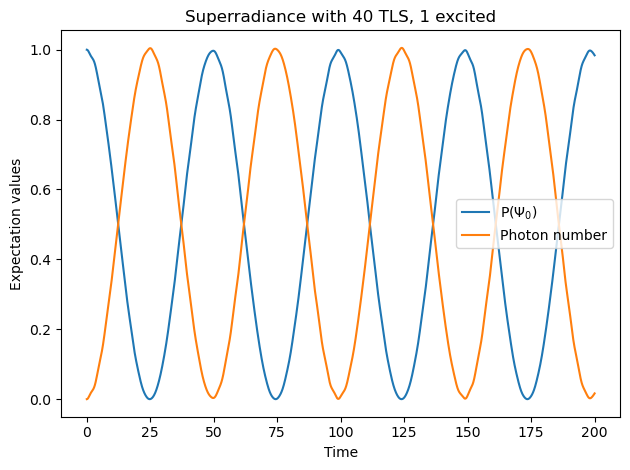

In [147]:
U=0.01
omega=1
deltaE=1

Ns = [2,4,8,16,32,40]
transfer_times = []
rates = []

for N in Ns:
    num_excited =  1
    max_bosons = num_excited*2
    
    two_state, bosons, interaction, number, nmm_list = make_operators(max_bosons=max_bosons, parity=0, num_TLS=N)

    psi_atom = basis(len(m_vals(N/2)), N-1)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom)
    
    H = deltaE*two_state  + bosons + U*interaction 
    
    
    # Time list
    tlist = np.linspace(0,  200, 4000)
    
    
    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    time_to_emit_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    
    transfer_times.append(time_to_emit_one)
    rates.append(2*np.pi / time_to_emit_one)

    print(f"time to transfer one = {time_to_emit_one}")

    plt.figure()
    
    plt.title(f"Superradiance with {N} TLS, {num_excited} excited")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0], label="P($\Psi_0$)")
    plt.plot(tlist, result.expect[1], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


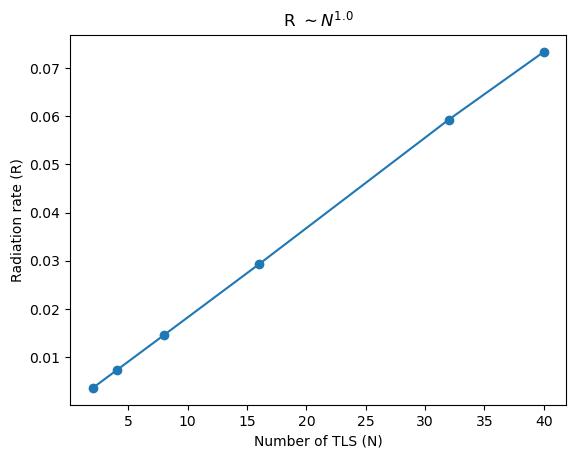

In [142]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Radiation rate (R)");

### N/2 TLS excited

time to transfer one = 103.97599399849963


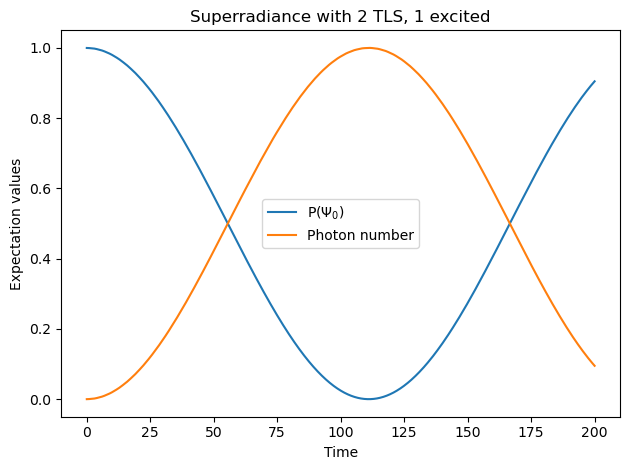

time to transfer one = 43.960990247561895


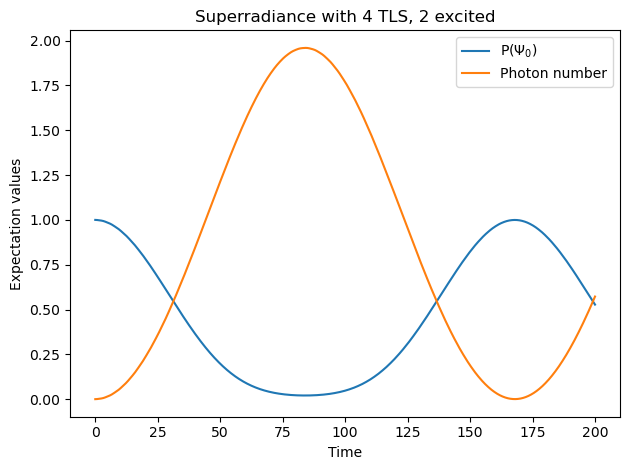

time to transfer one = 22.755688922230558


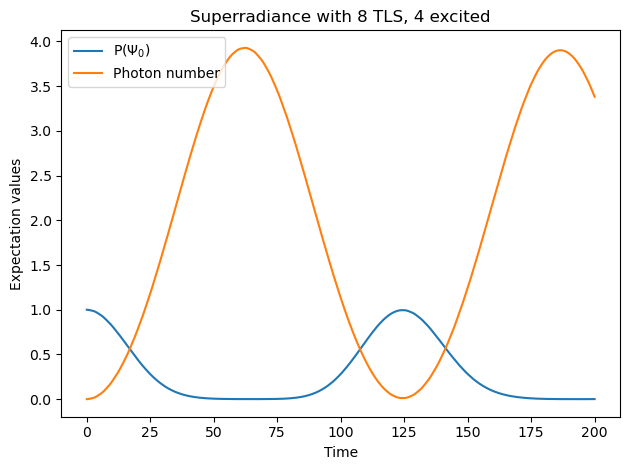

time to transfer one = 11.802950737684421


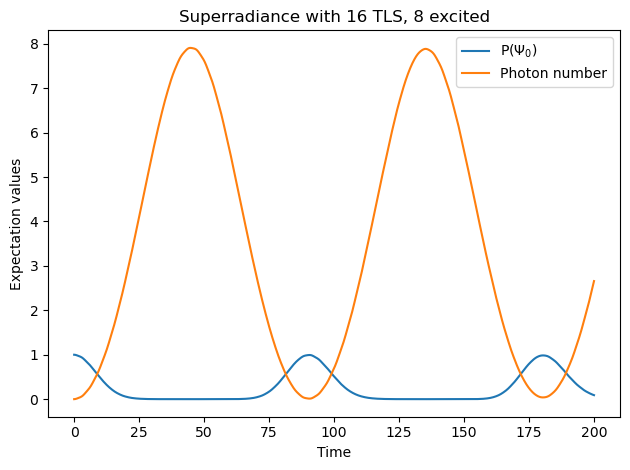

time to transfer one = 6.0515128782195555


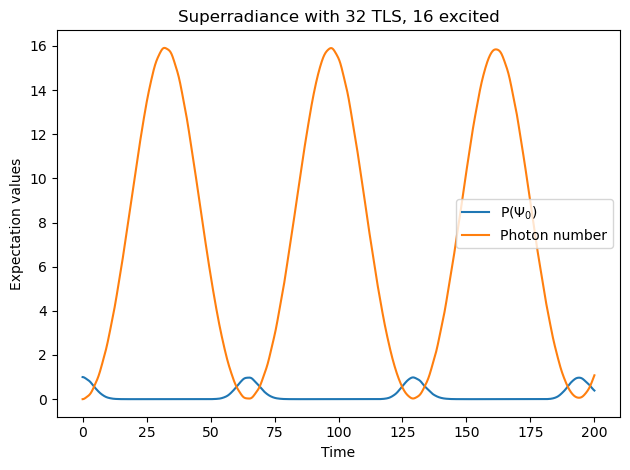

time to transfer one = 4.801200300075019


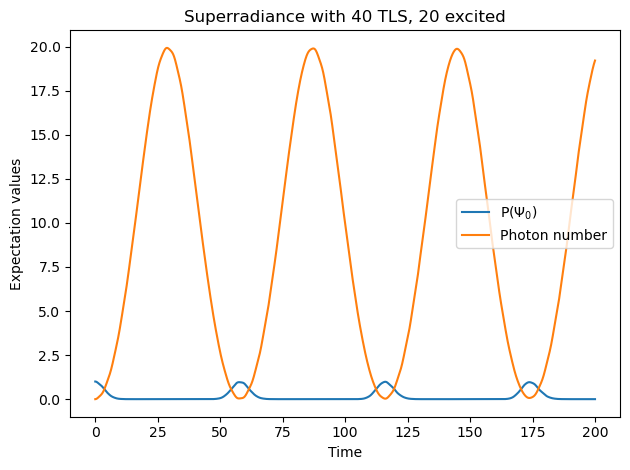

In [148]:
U=0.01
omega=1
deltaE=1
Ns = [2,4,8,16,32,40]
transfer_times = []
rates = []

for N in Ns:
    num_excited = N//2 or 1
    max_bosons = num_excited*2
    
    two_state, bosons, interaction, number, nmm_list = make_operators(max_bosons=max_bosons, parity=0, num_TLS=N)

    psi_atom = basis(len(m_vals(N/2)), N//2)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom)
    
    H = deltaE*two_state  + bosons + U*interaction 
    
    
    # Time list
    tlist = np.linspace(0,  200, 4000)
    
    
    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    time_to_emit_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    
    transfer_times.append(time_to_emit_one)
    rates.append(2*np.pi / time_to_emit_one)

    print(f"time to transfer one = {time_to_emit_one}")

    plt.figure()
    
    plt.title(f"Superradiance with {N} TLS, {num_excited} excited")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0], label="P($\Psi_0$)")
    plt.plot(tlist, result.expect[1], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


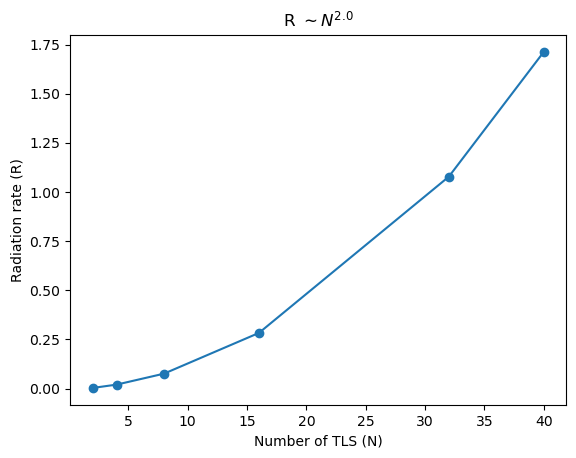

In [144]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Radiation rate (R)");


### TODO lots of chat about dicke
Also what about Parity? We should check that no?

## Supertransfer

In [154]:
def make_operators_AB(max_bosons, parity=0, num_TLS_A=1, num_TLS_B=1):
    
    JA     = jmat(0.5) if num_TLS_A==1 else jmat(num_TLS_A//2)
    JB     = jmat(0.5) if num_TLS_B==1 else jmat(num_TLS_B//2)
    JxA   = tensor(qeye(max_bosons+1), JA[0], qeye(JB[0].dims[0][0]))       # tensorised J𝑥 operator 
    JxB   = tensor(qeye(max_bosons+1), qeye(JA[0].dims[0][0]), JB[0])       # tensorised J𝑥 operator 
    JzA   = tensor(qeye(max_bosons+1), JA[2], qeye(JB[0].dims[0][0]))       # tensorised Jz operator 
    JzB   = tensor(qeye(max_bosons+1), qeye(JA[0].dims[0][0]), JB[2])       # tensorised Jz operator 
    a     = tensor(destroy(max_bosons+1), qeye(JA[0].dims[0][0]), qeye(JB[0].dims[0][0]))     # tensorised boson destruction operator

    two_state_A     = JzA                                 # two state system energy operator   Jz
    two_state_B     = JzB                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction_A   = 2*(a.dag() + a) * JxA               # interaction energy operator        2(𝑎†+𝑎)Jz  
    interaction_B   = 2*(a.dag() + a) * JxB               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + JzA + JzB + (num_TLS_A+num_TLS_B)/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = range(N, -1,-1)
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state_A       = two_state_A.extract_states(p)
        two_state_B       = two_state_B.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_A     = interaction_A.extract_states(p)
        interaction_B     = interaction_B.extract_states(p)
        nm_list        = [nm_list[i] for i in p]
  
    return two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list

### 1<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

time to transfer one = 41230.12301230123


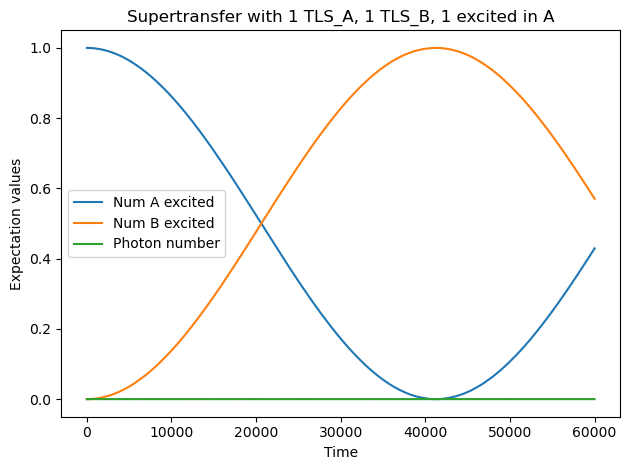

time to transfer one = 27482.74827482748


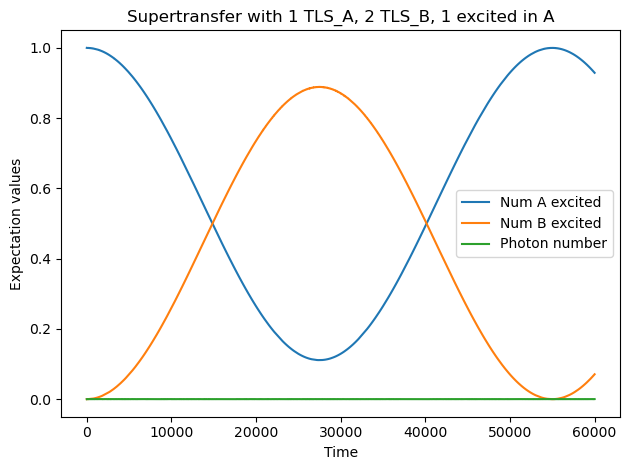

time to transfer one = 16495.649564956497


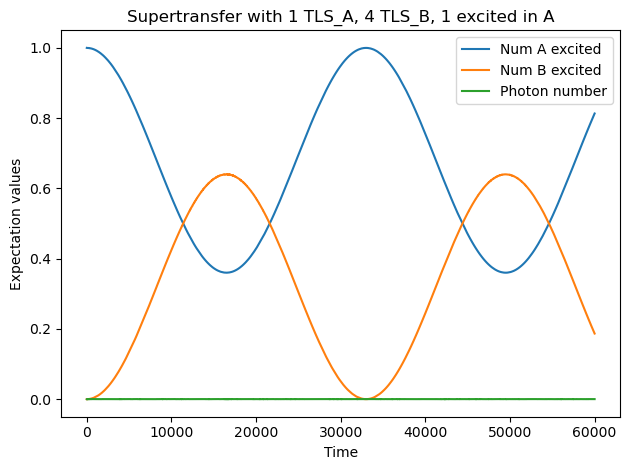

time to transfer one = 9156.915691569156


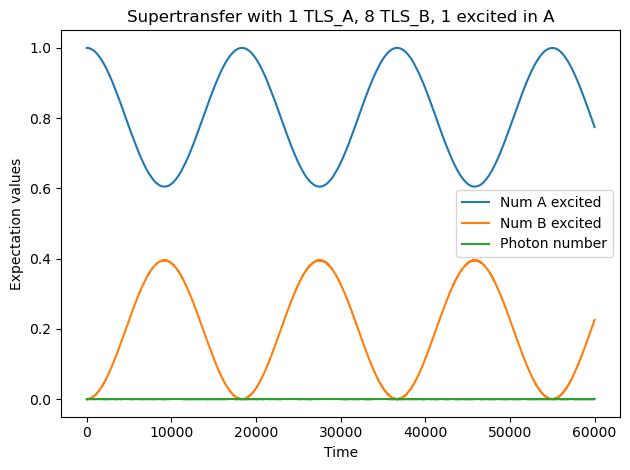

time to transfer one = 7506.750675067507


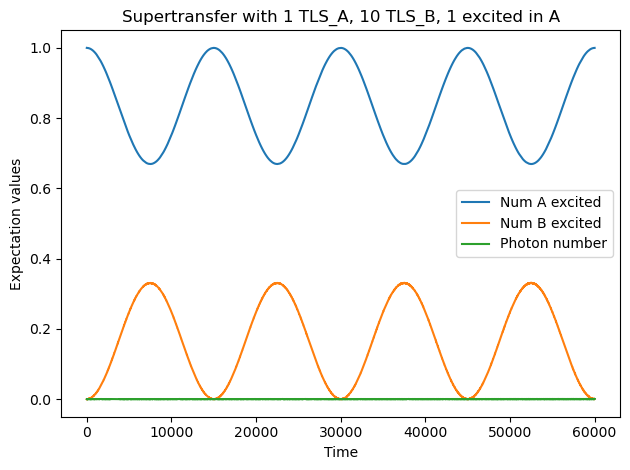

In [184]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,2,4,8,10]
transfer_times = []
rates = []

tend_ind = -1

for N in Ns:
    num_excited = 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list = make_operators_AB(max_bosons=max_bosons, parity=0, num_TLS_A=1, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(1/2)), 0)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  60000, 10000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    # time_to_transfer_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    tend_ind = np.argmin((result.expect[0][0:tend_ind]))
    time_to_transfer_one = tlist[tend_ind]    

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with 1 TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + 1/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


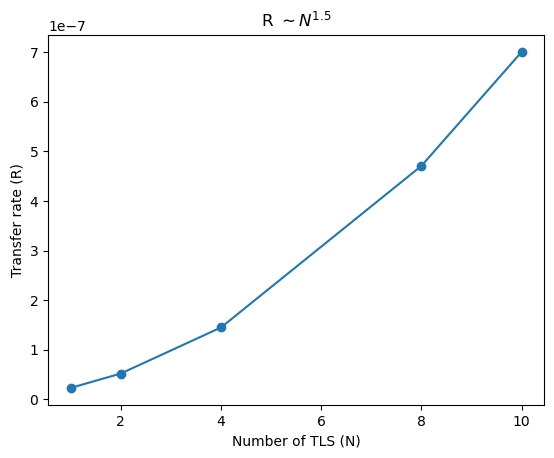

In [185]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");

### N<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

time to transfer one = 41230.12301230123


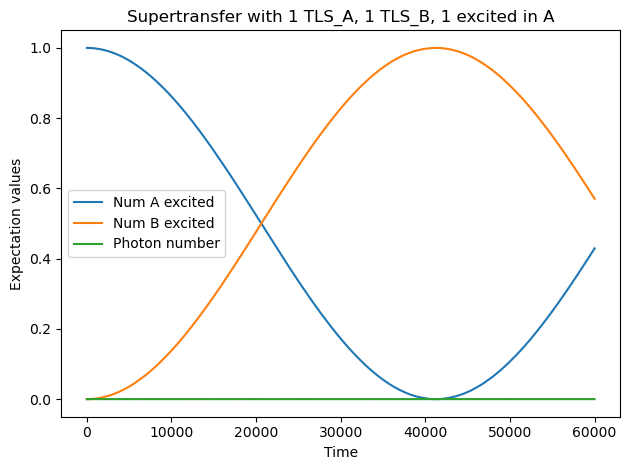

time to transfer one = 20642.06420642064


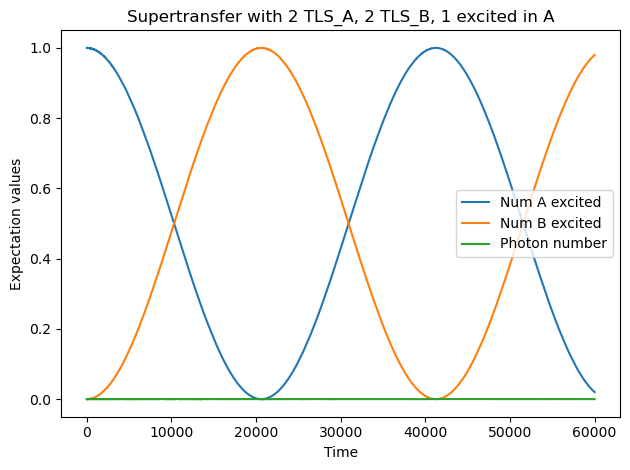

time to transfer one = 10303.030303030302


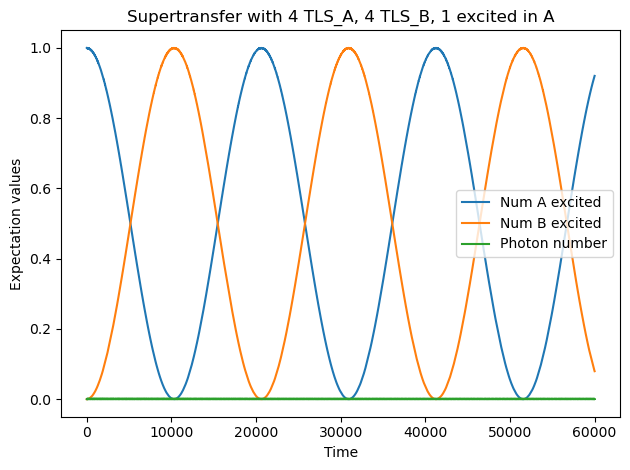

time to transfer one = 5154.515451545154


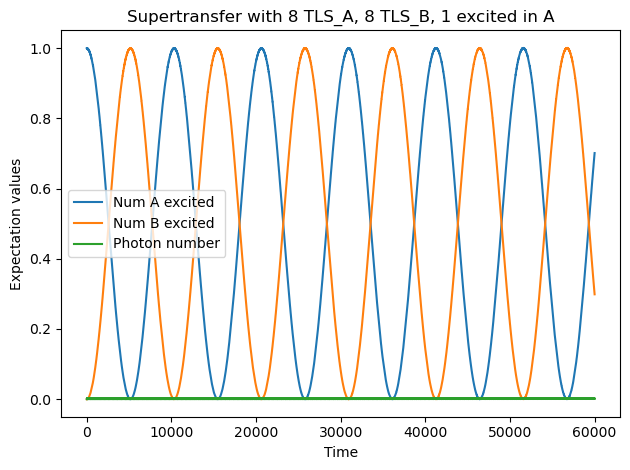

time to transfer one = 4122.412241224122


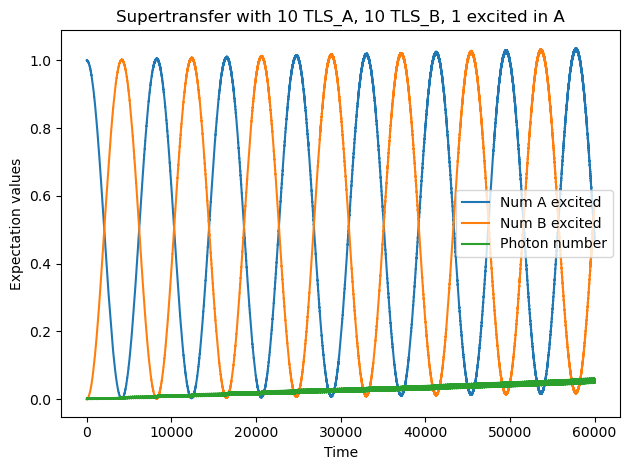

In [187]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,2,4,8,16]
transfer_times = []
rates = []

tend_ind = -1

for N in Ns:
    num_excited = 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list = make_operators_AB(max_bosons=max_bosons, parity=0, num_TLS_A=N, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(N/2)), N-1)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  60000, 10000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    # time_to_transfer_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    tend_ind = np.argmin((result.expect[0][0:tend_ind]))
    time_to_transfer_one = tlist[tend_ind]    

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


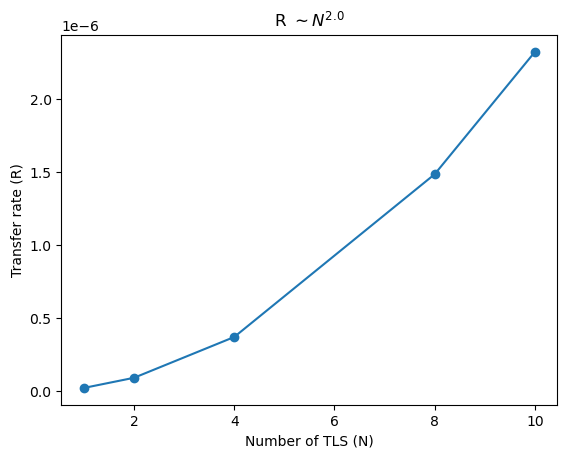

In [188]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");

### N<sub>A</sub> : N<sub>B</sub>,  N/2 TLS excited in A

time to transfer one = 38619.86198619862


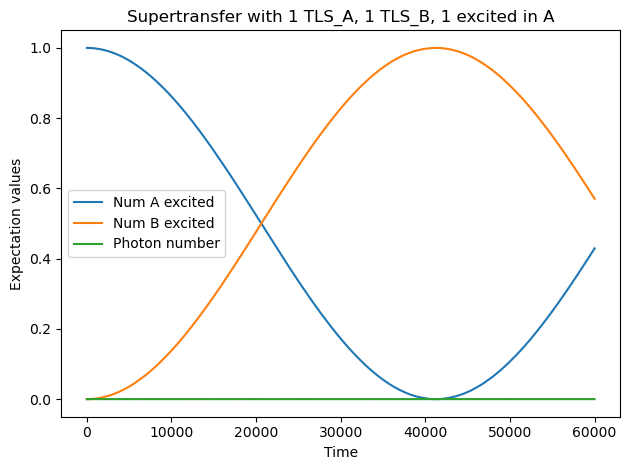

time to transfer one = 19315.724551753105


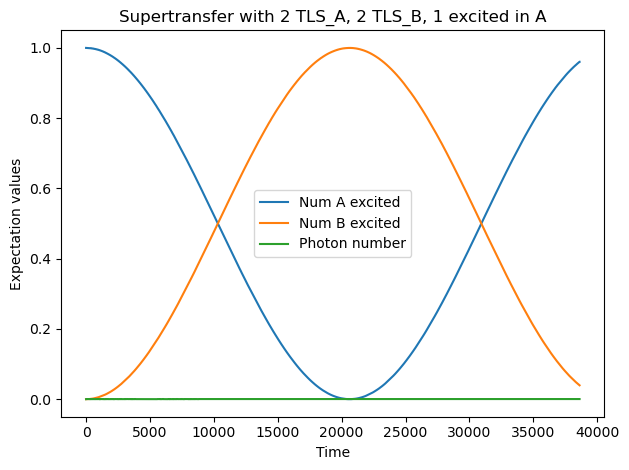

time to transfer one = 5980.7463958623475


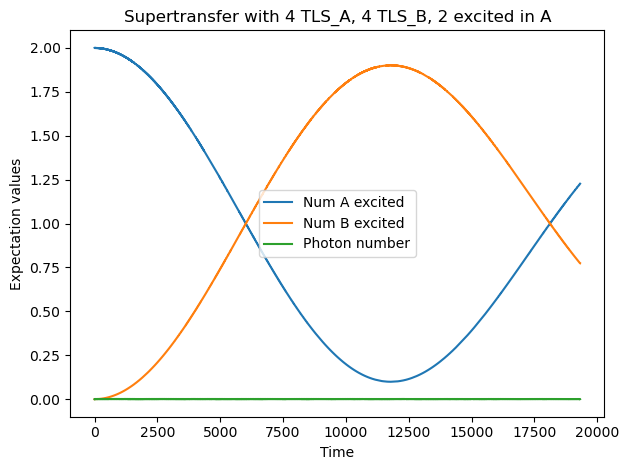

time to transfer one = 2170.629930051451


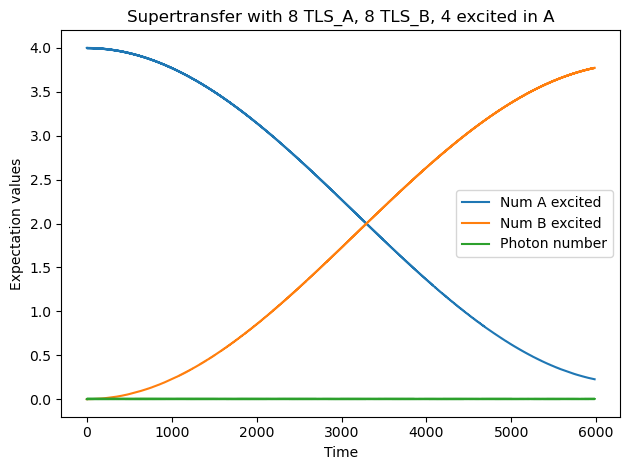

time to transfer one = 788.4516357582628


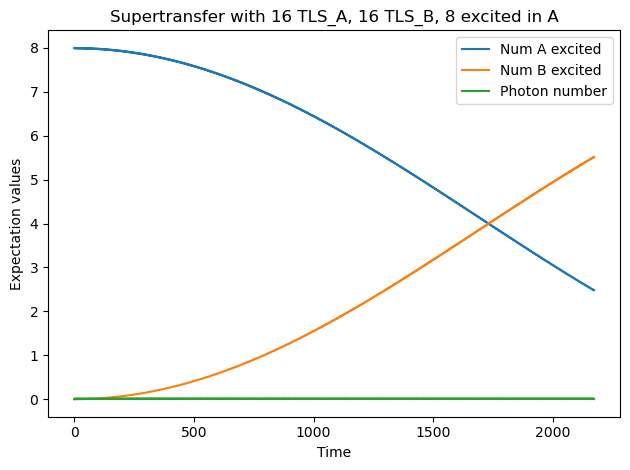

time to transfer one = 252.0143442227631


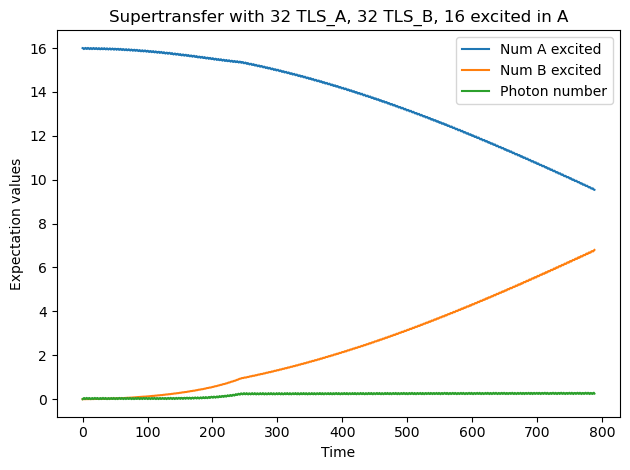

In [229]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,2,4,8,16,32]
transfer_times = []
rates = []

tend_ind = -1
tend = 60000


for N in Ns:
    num_excited = N//2 or 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list = make_operators_AB(max_bosons=max_bosons, parity=0, num_TLS_A=N, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(N/2)), N//2)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  tend, 10000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    tend_ind = np.where(np.abs((result.expect[1][0:-1]+ N/2 - 1))<0.01)[0][0]
    time_to_transfer_one = tlist[tend_ind]    
    tend = time_to_transfer_one

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


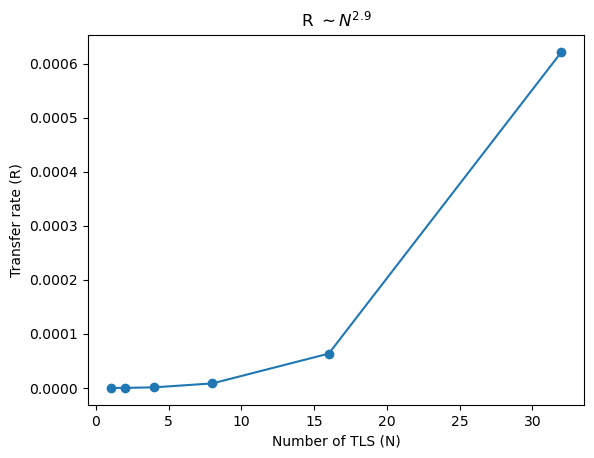

In [235]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");